In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the three CSV files
passengers = pd.read_csv('results/passengers.csv')
vehicles = pd.read_csv('results/vehicles.csv')
events = pd.read_csv('results/events.csv')



# Display basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nPassengers data shape: {passengers.shape}")
print(f"Vehicles data shape: {vehicles.shape}")
print(f"Events data shape: {events.shape}")

# Check for missing values
print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
print("\nPassengers missing values:")
print(passengers.isnull().sum())
print("\nVehicles missing values:")
print(vehicles.isnull().sum())

# Display first few rows
print("\n" + "=" * 80)
print("SAMPLE DATA")
print("=" * 80)
print("\nPassengers sample:")
print(passengers.head())
print("\nVehicles sample:")
print(vehicles.head())
print("\nEvents sample:")
print(events.head())

DATASET OVERVIEW

Passengers data shape: (4250, 11)
Vehicles data shape: (111, 9)
Events data shape: (390, 3)

MISSING VALUES

Passengers missing values:
passenger_id           0
origin                 0
destination            0
appear_time            0
board_time           223
arrival_time         257
status                 0
wait_time            223
travel_time          257
total_time           257
assigned_vehicle    4226
dtype: int64

Vehicles missing values:
vehicle_id          0
type                0
total_passengers    0
avg_occupancy       0
max_occupancy       0
occupancy_rate      0
total_boardings     0
total_alightings    0
stations_served     0
dtype: int64

SAMPLE DATA

Passengers sample:
  passenger_id   origin  destination  appear_time  board_time  arrival_time  \
0           P1  8589141      8589161    93.596712      1408.0        1903.0   
1           P2  8589141      8589161    34.850167       900.0         900.0   
2           P3  8589141      8589161   519.705687  

PASSENGER STATUS DISTRIBUTION

Total Passengers: 4,250

Status Breakdown:
  ARRIVED     :  3,993 (93.95%)
  WAITING     :    223 ( 5.25%)
  ONBOARD     :     34 ( 0.80%)

Service Rate:        93.95%
Abandonment Rate:    0.00%

WAITING TIME STATISTICS BY STATUS

ARRIVED:
  Count: 3,993
  Mean:  455.30 seconds (7.59 minutes)
  Median: 364.18 seconds
  Max:    3510.99 seconds
  Std:    389.75 seconds

ONBOARD:
  Count: 34
  Mean:  382.28 seconds (6.37 minutes)
  Median: 342.26 seconds
  Max:    893.35 seconds
  Std:    290.25 seconds

WAITING:
  Count: 223
  Mean:  nan seconds (nan minutes)
  Median: nan seconds
  Max:    nan seconds
  Std:    nan seconds


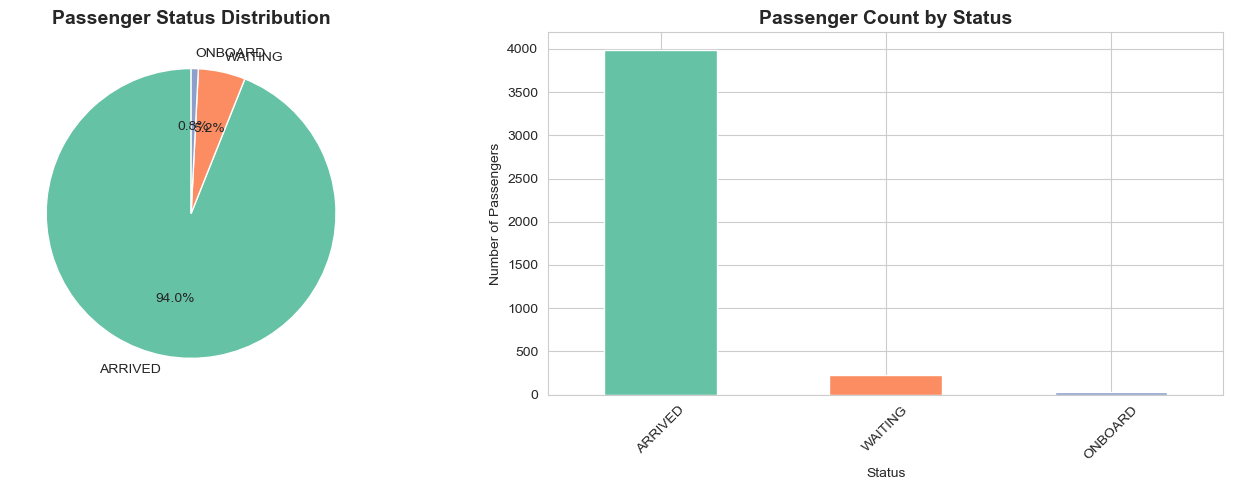

In [15]:
# Calculate basic statistics
total_passengers = len(passengers)
status_counts = passengers['status'].value_counts()
status_percentages = passengers['status'].value_counts(normalize=True) * 100

print("=" * 80)
print("PASSENGER STATUS DISTRIBUTION")
print("=" * 80)
print(f"\nTotal Passengers: {total_passengers:,}")
print("\nStatus Breakdown:")
for status in status_counts.index:
    count = status_counts[status]
    pct = status_percentages[status]
    print(f"  {status:12s}: {count:6,} ({pct:5.2f}%)")

# Calculate service rate (successfully arrived passengers)
service_rate = (status_counts.get('ARRIVED', 0) / total_passengers) * 100
abandonment_rate = (status_counts.get('ABANDONED', 0) / total_passengers) * 100

print(f"\n{'Service Rate:':<20} {service_rate:.2f}%")
print(f"{'Abandonment Rate:':<20} {abandonment_rate:.2f}%")

# Waiting time statistics by status
print("\n" + "=" * 80)
print("WAITING TIME STATISTICS BY STATUS")
print("=" * 80)
for status in passengers['status'].unique():
    subset = passengers[passengers['status'] == status]['wait_time']
    print(f"\n{status}:")
    print(f"  Count: {len(subset):,}")
    print(f"  Mean:  {subset.mean():.2f} seconds ({subset.mean()/60:.2f} minutes)")
    print(f"  Median: {subset.median():.2f} seconds")
    print(f"  Max:    {subset.max():.2f} seconds")
    print(f"  Std:    {subset.std():.2f} seconds")

# Visualization: Status distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("Set2"))
axes[0].set_title('Passenger Status Distribution', fontsize=14, fontweight='bold')

# Bar chart
status_counts.plot(kind='bar', ax=axes[1], color=sns.color_palette("Set2"))
axes[1].set_title('Passenger Count by Status', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Passengers')
axes[1].set_xlabel('Status')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

HOURLY ABANDONMENT ANALYSIS
             total_passengers  abandoned_count  abandonment_rate  service_rate
appear_hour                                                                   
0.0                       668                0               0.0         100.0
1.0                       683                0               0.0         100.0
2.0                       780                0               0.0         100.0
3.0                       798                0               0.0         100.0
4.0                       671                0               0.0         100.0
5.0                       650                0               0.0         100.0


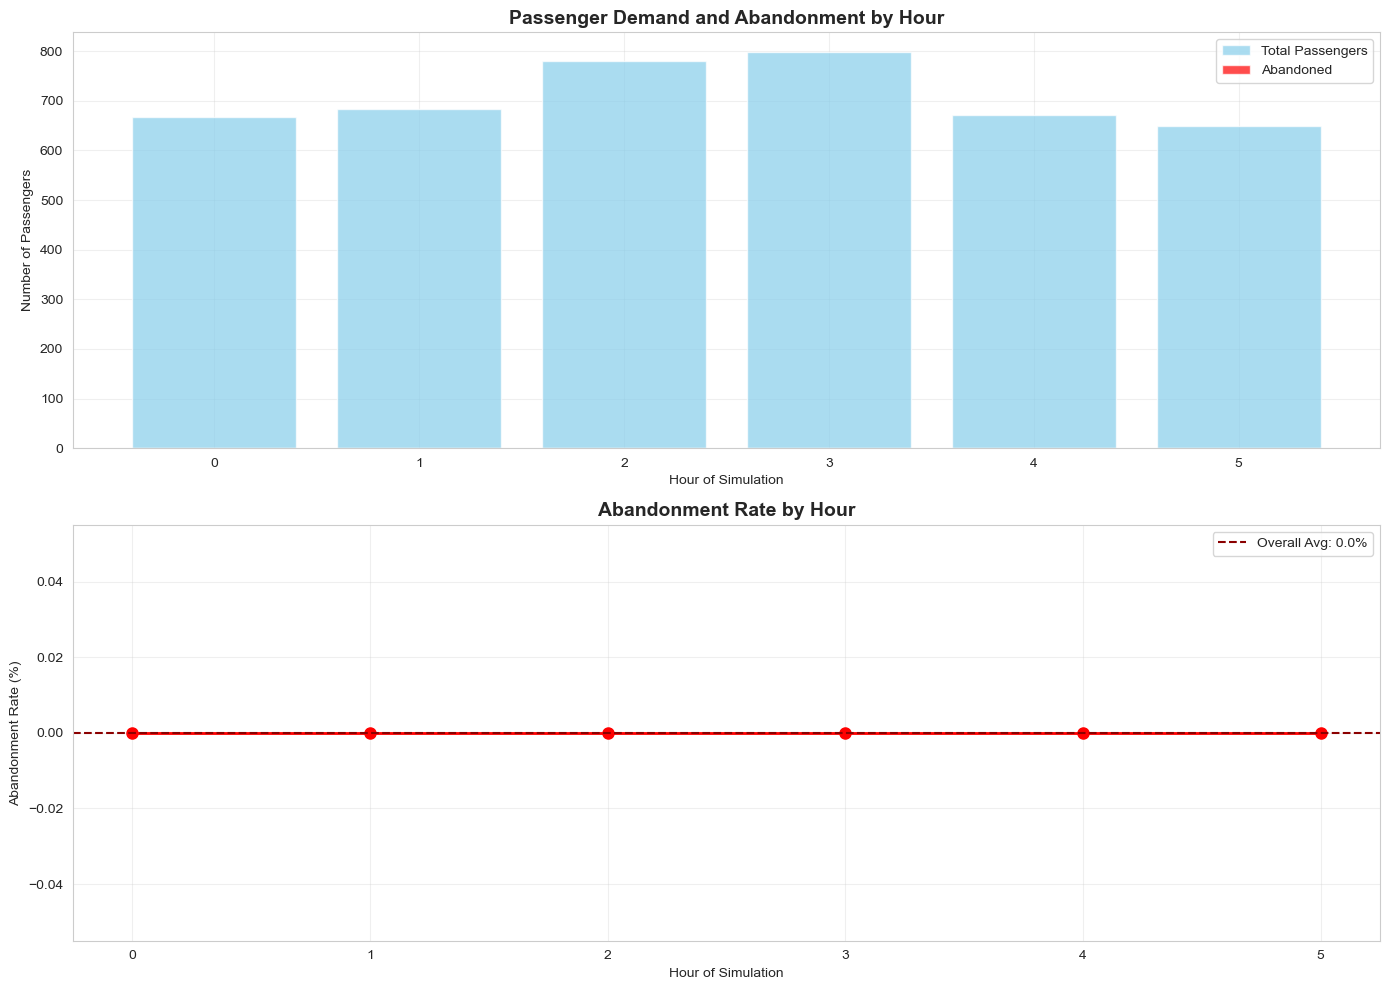


CRITICAL TIME PERIODS

Top 5 hours with highest abandonment rate:
             total_passengers  abandoned_count  abandonment_rate
appear_hour                                                     
0.0                       668                0               0.0
1.0                       683                0               0.0
2.0                       780                0               0.0
3.0                       798                0               0.0
4.0                       671                0               0.0


In [16]:
# Convert seconds to hours for temporal analysis
passengers['appear_hour'] = passengers['appear_time'] // 3600
passengers['appear_minute'] = (passengers['appear_time'] % 3600) // 60

# Analysis by hour
hourly_stats = passengers.groupby('appear_hour').agg({
    'passenger_id': 'count',
    'status': lambda x: (x == 'ABANDONED').sum()
}).rename(columns={'passenger_id': 'total_passengers', 'status': 'abandoned_count'})

hourly_stats['abandonment_rate'] = (hourly_stats['abandoned_count'] / hourly_stats['total_passengers']) * 100
hourly_stats['service_rate'] = 100 - hourly_stats['abandonment_rate']

print("=" * 80)
print("HOURLY ABANDONMENT ANALYSIS")
print("=" * 80)
print(hourly_stats.to_string())

# Visualization: Hourly patterns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Passenger demand by hour
axes[0].bar(hourly_stats.index, hourly_stats['total_passengers'], 
            color='skyblue', alpha=0.7, label='Total Passengers')
axes[0].bar(hourly_stats.index, hourly_stats['abandoned_count'], 
            color='red', alpha=0.7, label='Abandoned')
axes[0].set_xlabel('Hour of Simulation')
axes[0].set_ylabel('Number of Passengers')
axes[0].set_title('Passenger Demand and Abandonment by Hour', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Abandonment rate by hour
axes[1].plot(hourly_stats.index, hourly_stats['abandonment_rate'], 
             marker='o', linewidth=2, markersize=8, color='red')
axes[1].fill_between(hourly_stats.index, hourly_stats['abandonment_rate'], 
                      alpha=0.3, color='red')
axes[1].set_xlabel('Hour of Simulation')
axes[1].set_ylabel('Abandonment Rate (%)')
axes[1].set_title('Abandonment Rate by Hour', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=abandonment_rate, color='darkred', linestyle='--', 
                label=f'Overall Avg: {abandonment_rate:.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

# Identify peak abandonment hours
print("\n" + "=" * 80)
print("CRITICAL TIME PERIODS")
print("=" * 80)
top_abandonment_hours = hourly_stats.nlargest(5, 'abandonment_rate')
print("\nTop 5 hours with highest abandonment rate:")
print(top_abandonment_hours[['total_passengers', 'abandoned_count', 'abandonment_rate']])

In [17]:
import json

# Load station data
with open('stations.json', 'r', encoding='utf-8') as f:
    station_data = json.load(f)

# Create station lookup dictionaries using station_id (as STRING)
station_id_to_name = {str(station['station_id']): station['name'] for station in station_data['stations']}
station_id_to_index = {str(station['station_id']): station['index'] for station in station_data['stations']}
station_index_to_name = {station['index']: station['name'] for station in station_data['stations']}

print("=" * 80)
print("STATION DATA LOADED")
print("=" * 80)
print(f"Total stations: {len(station_data['stations'])}")
print("\nStation ID to Name mapping sample:")
for i, (sid, name) in enumerate(list(station_id_to_name.items())[:5]):
    print(f"  ID {sid}: {name}")

# Convert origin and destination to string (in case they're integers)
passengers['origin'] = passengers['origin'].astype(str)
passengers['destination'] = passengers['destination'].astype(str)

# Add station names to passengers dataframe using station_id
passengers['origin_name'] = passengers['origin'].map(station_id_to_name)
passengers['destination_name'] = passengers['destination'].map(station_id_to_name)

# Check for any unmapped stations
unmapped_origins = passengers[passengers['origin_name'].isna()]['origin'].unique()
unmapped_destinations = passengers[passengers['destination_name'].isna()]['destination'].unique()

if len(unmapped_origins) > 0 or len(unmapped_destinations) > 0:
    print("\n⚠️  WARNING: Some stations could not be mapped:")
    if len(unmapped_origins) > 0:
        print(f"  Unmapped origin IDs: {unmapped_origins[:10]}...")  # Show first 10
        print(f"  Total unmapped origins: {len(unmapped_origins)}")
    if len(unmapped_destinations) > 0:
        print(f"  Unmapped destination IDs: {unmapped_destinations[:10]}...")
        print(f"  Total unmapped destinations: {len(unmapped_destinations)}")
    
    # Check if the IDs in passengers are actually in the station data
    print("\n  Available station IDs in stations.json:")
    print(f"  {list(station_id_to_name.keys())[:5]}... (first 5)")
    print(f"\n  Station IDs in passengers.csv (origin):")
    print(f"  {passengers['origin'].unique()[:5]}... (first 5)")
else:
    print("\n✓ All stations successfully mapped to names")

# Display sample with station names
print("\n" + "=" * 80)
print("PASSENGER DATA WITH STATION NAMES (Sample)")
print("=" * 80)
sample_df = passengers[['passenger_id', 'origin', 'origin_name', 'destination', 
                         'destination_name', 'status', 'wait_time']].head(10)
print(sample_df.to_string())

# Summary of mapping success
total_passengers_with_names = passengers[passengers['origin_name'].notna() & 
                                          passengers['destination_name'].notna()]
mapping_success_rate = len(total_passengers_with_names) / len(passengers) * 100
print(f"\n{'Mapping success rate:':<30} {mapping_success_rate:.1f}%")
print(f"{'Passengers with valid names:':<30} {len(total_passengers_with_names):,} / {len(passengers):,}")

STATION DATA LOADED
Total stations: 22

Station ID to Name mapping sample:
  ID 8589141: Fribourg, Chaley
  ID 8589152: Fribourg, Mon-Repos
  ID 8589138: Fribourg, Cité-Jardins
  ID 8591766: Fribourg, Boschung
  ID 8587255: Fribourg, Tilleul/Cathédrale

✓ All stations successfully mapped to names

PASSENGER DATA WITH STATION NAMES (Sample)
  passenger_id   origin             origin_name destination             destination_name   status    wait_time
0           P1  8589141        Fribourg, Chaley     8589161          Fribourg, St-Pierre  ARRIVED  1314.403288
1           P2  8589141        Fribourg, Chaley     8589161          Fribourg, St-Pierre  ARRIVED   865.149833
2           P3  8589141        Fribourg, Chaley     8589161          Fribourg, St-Pierre  ARRIVED   888.294313
3           P4  8589141        Fribourg, Chaley     8589161          Fribourg, St-Pierre  ARRIVED  1047.330993
4           P5  8589152     Fribourg, Mon-Repos     8589161          Fribourg, St-Pierre  ARRIVED  1279

ANALYSIS SCOPE
Total passengers in dataset: 4,250
Passengers with valid station names: 4,250
Passengers excluded (unmapped stations): 0

ABANDONMENT BY ORIGIN STATION (WITH NAMES)
                                total_passengers  abandoned_count  abandonment_rate
origin_name                                                                        
Fribourg, Bertigny                           201                0               0.0
Fribourg, Windig                             158                0               0.0
Villars-sur-Glâne,Jean Paul II                31                0               0.0
Villars-sur-Glâne, Méridienne                 73                0               0.0
Villars-sur-Glâne, Moncor                     65                0               0.0
Villars-sur-Glâne, Hôp. cant.                159                0               0.0
Villars-sur-Glâne, Belle-Croix               260                0               0.0
Fribourg/Freiburg, Pl. Gare                 1918                

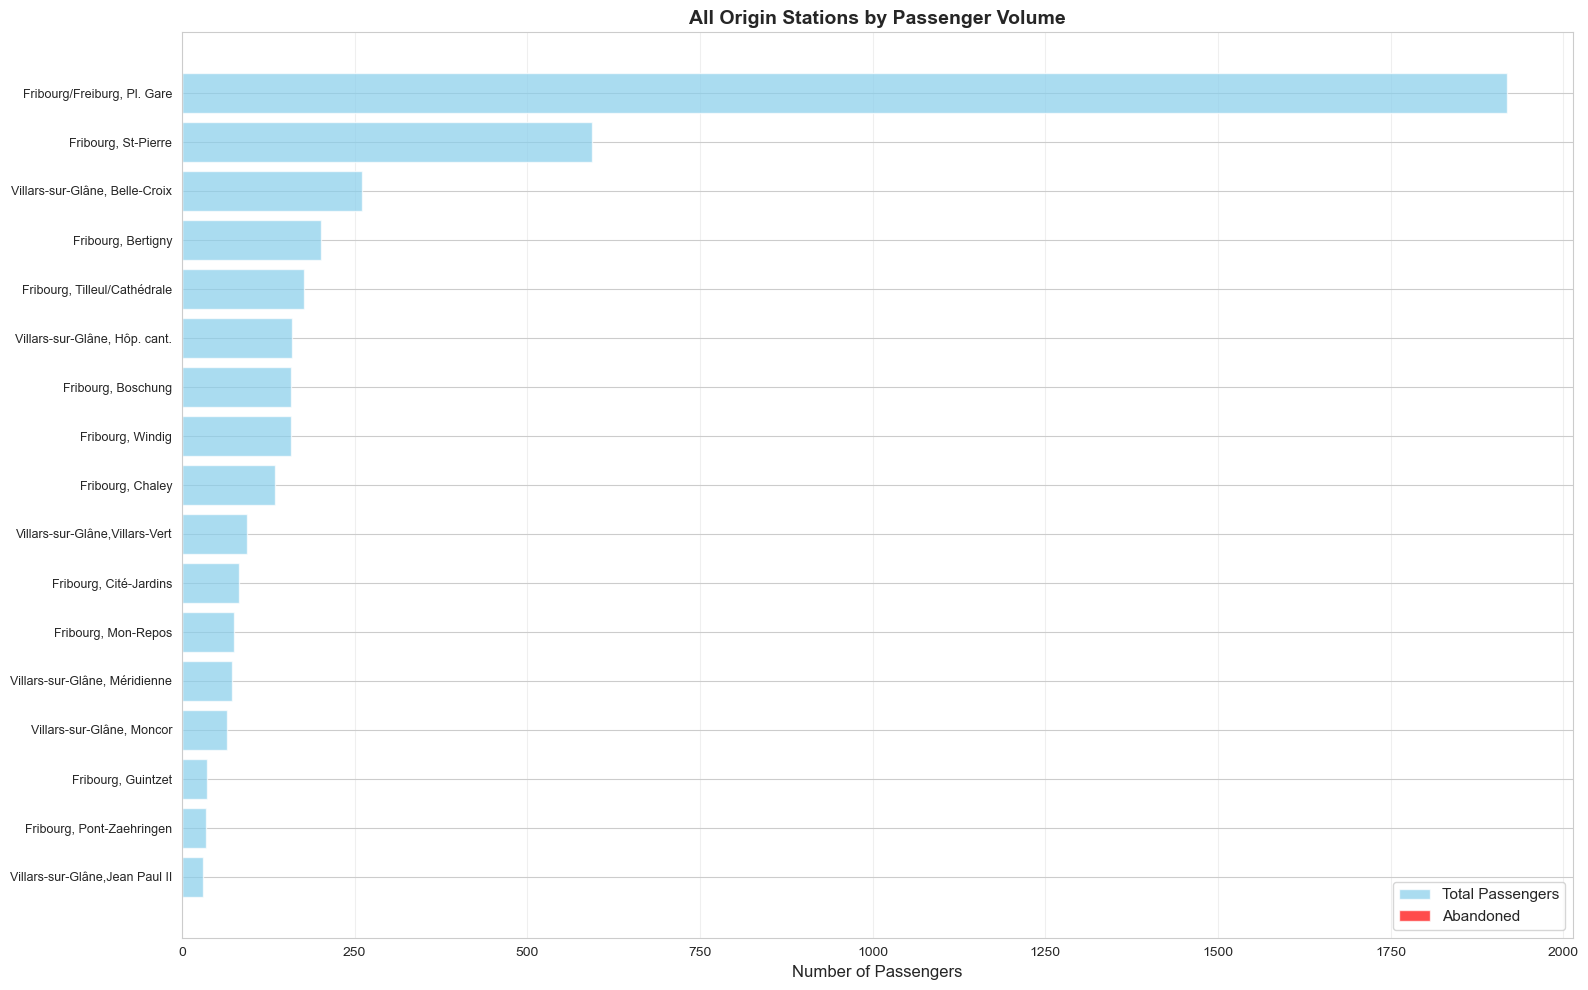

In [18]:
# Filter out passengers with unmapped stations for clean analysis
passengers_valid = passengers[passengers['origin_name'].notna() & 
                               passengers['destination_name'].notna()].copy()

print("=" * 80)
print("ANALYSIS SCOPE")
print("=" * 80)
print(f"Total passengers in dataset: {len(passengers):,}")
print(f"Passengers with valid station names: {len(passengers_valid):,}")
print(f"Passengers excluded (unmapped stations): {len(passengers) - len(passengers_valid):,}")

# Recalculate origin stats with station names
origin_stats_named = passengers_valid.groupby('origin_name').agg({
    'passenger_id': 'count',
    'status': lambda x: (x == 'ABANDONED').sum()
}).rename(columns={'passenger_id': 'total_passengers', 'status': 'abandoned_count'})

origin_stats_named['abandonment_rate'] = (origin_stats_named['abandoned_count'] / 
                                           origin_stats_named['total_passengers']) * 100
origin_stats_named = origin_stats_named.sort_values('abandonment_rate', ascending=False)

print("\n" + "=" * 80)
print("ABANDONMENT BY ORIGIN STATION (WITH NAMES)")
print("=" * 80)
print(origin_stats_named.to_string())

# Top problematic stations with names
print("\n" + "=" * 80)
print("TOP 10 MOST PROBLEMATIC STATIONS")
print("=" * 80)
top_problematic_named = origin_stats_named.nlargest(10, 'abandonment_rate')
print(top_problematic_named.to_string())

# Stations with 100% abandonment
no_service_stations_named = origin_stats_named[origin_stats_named['abandonment_rate'] == 100]
print(f"\n{'Stations with 0% service:':<30} {len(no_service_stations_named)}")
if len(no_service_stations_named) > 0:
    print(f"{'Total affected passengers:':<30} {no_service_stations_named['total_passengers'].sum()}")
    print("\nStations with NO service:")
    for station_name in no_service_stations_named.index:
        pax_count = no_service_stations_named.loc[station_name, 'total_passengers']
        print(f"  - {station_name}: {pax_count} passengers")

# Stations with best service
print("\n" + "=" * 80)
print("TOP 5 BEST PERFORMING STATIONS (lowest abandonment)")
print("=" * 80)
best_stations = origin_stats_named.nsmallest(5, 'abandonment_rate')
print(best_stations.to_string())

# Visualization: ALL stations by passenger volume
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Sort by total passengers for better visualization
all_stations_sorted = origin_stats_named.sort_values('total_passengers', ascending=True)
y_pos = np.arange(len(all_stations_sorted))

ax.barh(y_pos, all_stations_sorted['total_passengers'], color='skyblue', 
        alpha=0.7, label='Total Passengers')
ax.barh(y_pos, all_stations_sorted['abandoned_count'], color='red', 
        alpha=0.7, label='Abandoned')
ax.set_yticks(y_pos)
ax.set_yticklabels(all_stations_sorted.index, fontsize=9)
ax.set_xlabel('Number of Passengers', fontsize=12)
ax.set_title('All Origin Stations by Passenger Volume', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

OD PAIR ANALYSIS (WITH STATION NAMES)
Total OD pairs: 43
OD pairs with 100% abandonment: 0

TOP 20 MOST PROBLEMATIC OD PAIRS
                                                                                 origin_name                destination_name  total_passengers  abandoned_count  abandonment_rate
od_pair_named                                                                                                                                                                    
Fribourg, Bertigny → Fribourg/Freiburg, Pl. Gare                          Fribourg, Bertigny     Fribourg/Freiburg, Pl. Gare               201                0               0.0
Fribourg/Freiburg, Pl. Gare → Villars-sur-Glâne, Hôp. cant.      Fribourg/Freiburg, Pl. Gare   Villars-sur-Glâne, Hôp. cant.               110                0               0.0
Fribourg/Freiburg, Pl. Gare → Fribourg, Cité-Jardins             Fribourg/Freiburg, Pl. Gare          Fribourg, Cité-Jardins                81                0    

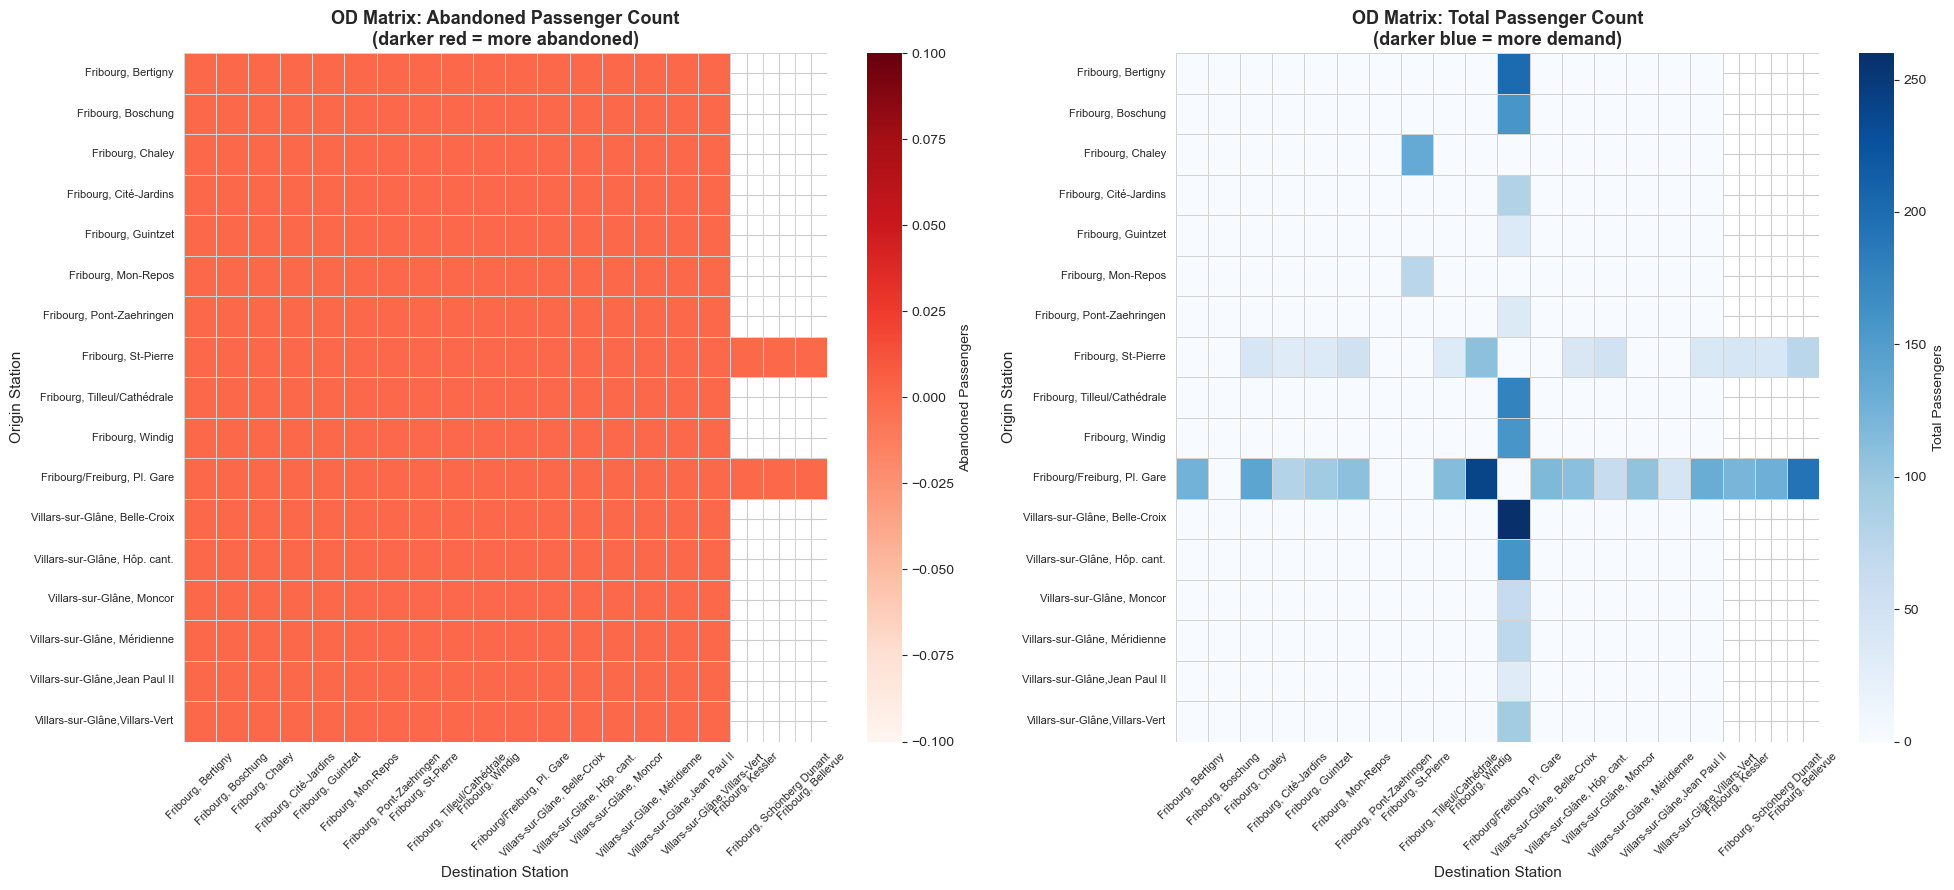

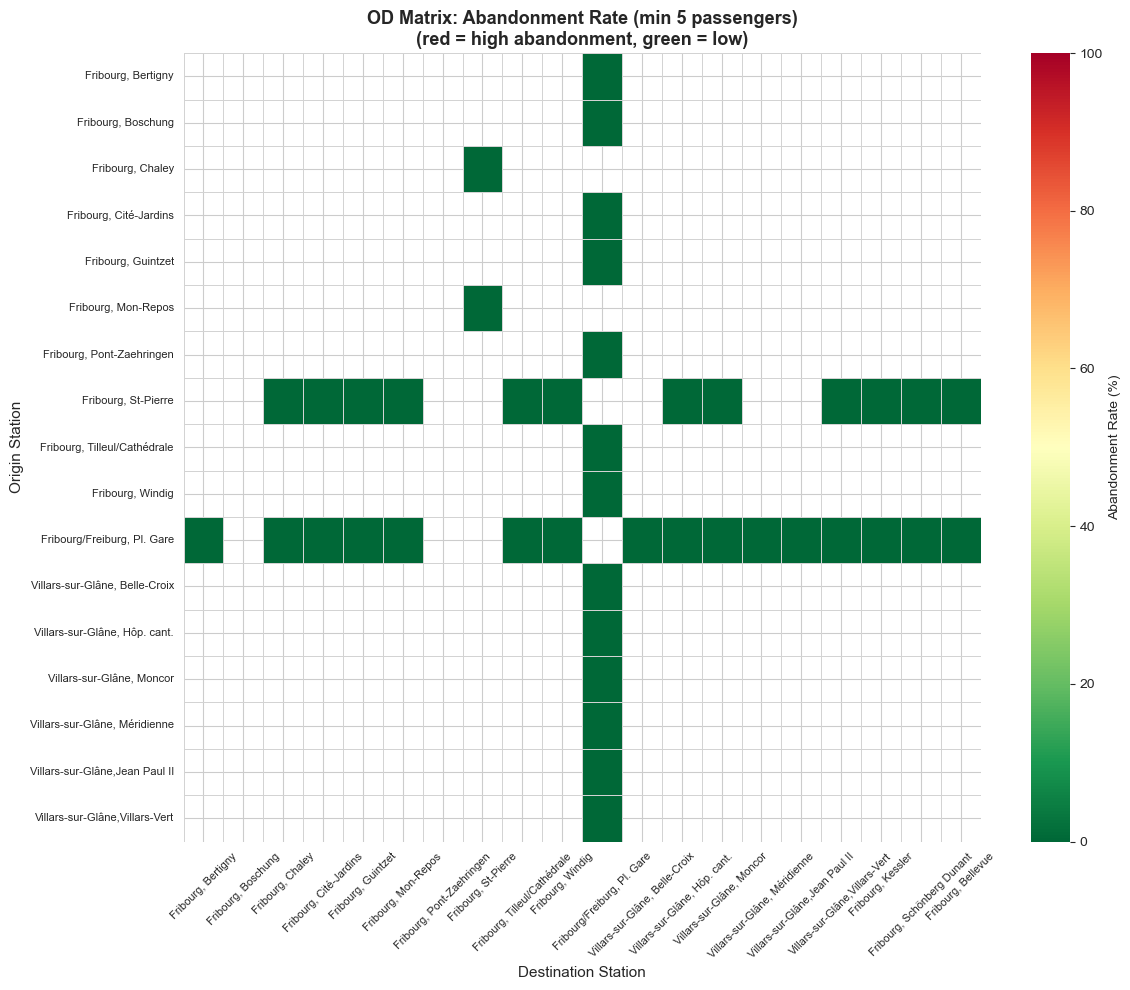

In [19]:
# Create OD pair with station names (using valid passengers only)
passengers_valid['od_pair_named'] = (passengers_valid['origin_name'] + ' → ' + 
                                      passengers_valid['destination_name'])

# Analysis by OD pair with names
od_stats_named = passengers_valid.groupby('od_pair_named').agg({
    'passenger_id': 'count',
    'status': lambda x: (x == 'ABANDONED').sum(),
    'origin_name': 'first',
    'destination_name': 'first'
}).rename(columns={'passenger_id': 'total_passengers', 'status': 'abandoned_count'})

od_stats_named['abandonment_rate'] = (od_stats_named['abandoned_count'] / 
                                       od_stats_named['total_passengers']) * 100
od_stats_named = od_stats_named.sort_values('abandonment_rate', ascending=False)

print("=" * 80)
print("OD PAIR ANALYSIS (WITH STATION NAMES)")
print("=" * 80)
print(f"Total OD pairs: {len(od_stats_named)}")
print(f"OD pairs with 100% abandonment: {len(od_stats_named[od_stats_named['abandonment_rate'] == 100])}")

# Top problematic OD pairs
print("\n" + "=" * 80)
print("TOP 20 MOST PROBLEMATIC OD PAIRS")
print("=" * 80)
top_od_named = od_stats_named.nlargest(20, 'abandonment_rate')
print(top_od_named[['origin_name', 'destination_name', 'total_passengers', 
                     'abandoned_count', 'abandonment_rate']].to_string())

# High-volume OD pairs with high abandonment
print("\n" + "=" * 80)
print("HIGH-VOLUME OD PAIRS WITH HIGH ABANDONMENT (>50%, min 10 passengers)")
print("=" * 80)
high_volume_high_abandon_named = od_stats_named[
    (od_stats_named['total_passengers'] >= 10) & 
    (od_stats_named['abandonment_rate'] > 50)
].sort_values('total_passengers', ascending=False)
print(high_volume_high_abandon_named[['origin_name', 'destination_name', 
                                       'total_passengers', 'abandoned_count', 
                                       'abandonment_rate']].head(20).to_string())

# Best performing OD pairs
print("\n" + "=" * 80)
print("TOP 10 BEST PERFORMING OD PAIRS (lowest abandonment, min 10 passengers)")
print("=" * 80)
best_od = od_stats_named[od_stats_named['total_passengers'] >= 10].nsmallest(10, 'abandonment_rate')
print(best_od[['origin_name', 'destination_name', 'total_passengers', 
               'abandoned_count', 'abandonment_rate']].to_string())

# Create OD matrix for heatmap - using abandoned passenger count
# Get unique station names in consistent order
unique_stations = sorted(passengers_valid['origin_name'].unique())

# Initialize matrices
od_matrix_abandoned = pd.DataFrame(0, index=unique_stations, columns=unique_stations)
od_matrix_total = pd.DataFrame(0, index=unique_stations, columns=unique_stations)

# Fill the matrices
for _, row in od_stats_named.iterrows():
    origin = row['origin_name']
    destination = row['destination_name']
    od_matrix_abandoned.loc[origin, destination] = row['abandoned_count']
    od_matrix_total.loc[origin, destination] = row['total_passengers']

# Visualization: OD Heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Heatmap 1: Abandoned passenger count
sns.heatmap(od_matrix_abandoned, annot=False, fmt='g', cmap='Reds', 
            cbar_kws={'label': 'Abandoned Passengers'}, ax=axes[0],
            linewidths=0.5, linecolor='lightgray')
axes[0].set_title('OD Matrix: Abandoned Passenger Count\n(darker red = more abandoned)', 
                   fontsize=13, fontweight='bold')
axes[0].set_xlabel('Destination Station', fontsize=11)
axes[0].set_ylabel('Origin Station', fontsize=11)
axes[0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0].tick_params(axis='y', rotation=0, labelsize=8)

# Heatmap 2: Total passenger count (for comparison)
sns.heatmap(od_matrix_total, annot=False, fmt='g', cmap='Blues', 
            cbar_kws={'label': 'Total Passengers'}, ax=axes[1],
            linewidths=0.5, linecolor='lightgray')
axes[1].set_title('OD Matrix: Total Passenger Count\n(darker blue = more demand)', 
                   fontsize=13, fontweight='bold')
axes[1].set_xlabel('Destination Station', fontsize=11)
axes[1].set_ylabel('Origin Station', fontsize=11)
axes[1].tick_params(axis='x', rotation=45, labelsize=8)
axes[1].tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

# Additional: Abandonment rate heatmap (only for pairs with at least 5 passengers)
od_matrix_rate = od_matrix_abandoned / od_matrix_total.replace(0, np.nan) * 100
# Mask cells with less than 5 passengers
od_matrix_rate_masked = od_matrix_rate.where(od_matrix_total >= 5)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(od_matrix_rate_masked, annot=False, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Abandonment Rate (%)'}, ax=ax,
            linewidths=0.5, linecolor='lightgray', vmin=0, vmax=100,
            mask=od_matrix_rate_masked.isna())
ax.set_title('OD Matrix: Abandonment Rate (min 5 passengers)\n(red = high abandonment, green = low)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Destination Station', fontsize=11)
ax.set_ylabel('Origin Station', fontsize=11)
ax.tick_params(axis='x', rotation=45, labelsize=8)
ax.tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()